## COGS 182 Homework 2
Malachi Mabie 
20 Jan 2021

### Code for questions 1 and 2

Figure 2.2 compares a greedy method with two $\epsilon$-greedy methods ($\epsilon=0.01$ and $\epsilon=0.1$), on the 10-armed testbed. All the methods formed their action-value estimates using the sample-average technique (w/ initial estimate of 0).

prof: Besides the pseudocode "A simple bandit algorithm", the only thing you really need for solving Questions 1 and 2 is to specify the function bandit(A), which takes an action as input and outputs a reward


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [10]:
# testbed - contains states, actions, and overall rules.
#     Heavy inspiration from https://github.com/jettdlee/10_armed_bandit/blob/master/10_bandit_testbed.py
class Testbed(object):
  def __init__(self, arm_count, mean, std):
      self.arm_count = arm_count
      self.mean = mean
      self.std = std

      self.action_vals = np.zeros(arm_count)
      self.optimal_val = 0
      self.reset()
    
  def reset(self):
      # initialize with gaussian or normal values.
      self.action_vals = np.random.normal(self.mean, self.std, self.arm_count)
      # identify action array's maximum value.
      self.optimal_val = np.argmax(self.action_vals)

In [23]:
# agent - controls agent's movement and behavior when interacting with testbed.
#         Two types defined: greedy, and epsilon-greedy.
#     Receives info on current position.
class Agent(object):
  def __init__(self, arm_count, e_prob=0, init_est=0):
      self.arm_count = arm_count
      self.e_prob = e_prob # e_prob = epsilon probability

      self.time_step = 0      # what time step we're at
      self.last_action = None # last action object

      self.k_action = np.zeros(arm_count)   # actions taken at time step
      self.reward_sum = np.zeros(arm_count) # sum number of rewards
      self.value_est = np.full(arm_count, fill_value=init_est)
      # action value estimates Qt ~= Q*(a)

  def __str__(self):
      return "Greedy" if self.e_prob == 0 else "Epsilon = " + str(self.e_prob)
  
  # action - select based on epsilon-greedy behavior.
  #     If epsilon is zero, then agent performs a greedy selection.
  def action(self):
      # POLICY - add or change here. Using epsilon method.
      r_prob = np.random.random() # random probability 0-1.

      if r_prob < self.e_prob: # exploratory
        a = np.random.choice(len(self.value_est)) # select random action
      else: # greedy
        max_action = np.argmax(self.value_est) # find maximum value estimate
        # get all actions with that max value:
        action = np.where(self.value_est == np.argmax(self.value_est))[0]
        # if multiple actions, choose randomly.
        a = (max_action if len(action) == 0 else np.random.choice(action))
      
      # save and return result.
      self.last_action = a
      return a
  
  # interpreter - updates value estimates based on last action.
  #     Receives the reward from last_action.
  def interpreter(self, reward):
      At = self.last_action

      self.k_action[At] += 1        # increment action selection
      self.reward_sum[At] += reward # copy down reward to appropriate spot

      # calculate new action value
      self.value_est[At] = self.reward_sum[At]/self.k_action[At]

      self.time_step += 1           # increment time step
  
  # reset - reset all object vars for next iteration.
  def reset(self):
      self.time_step = 0
      self.last_action = None
      self.k_action[:] = 0
      self.reward_sum[:] = 0
      self.value_est[:] = 0
  

In [14]:
# Environment class - to control agent & testbed objects
class Environment(object):
  def __init__(self, testbed, agents, plays, iterations):
      self.testbed = testbed
      self.agents = agents
      self.plays = plays
      self.iterations = iterations

  # run test
  def play(self):
    scores = np.zeros((self.plays, len(self.agents))) # store the agents' scores
    optimals = np.zeros((self.plays, len(self.agents))) # maintain optimal count

    # outer loop for iteration count
    for i in range(self.iterations):
      # FORMATTING: print update every 100 iterations
      if not (i % 100): print("Completed Iterations: ", i)

      # reset objects prior to inner loop of plays:
      self.testbed.reset()
      for agent in self.agents: agent.reset()

      # middle loop for number of plays
      for j in range(self.plays):
        agent_j = 0

        # inner loop for number of agents
        for k in self.agents:
          action = k.action()
          # METHOD: reward determined by normal dist Q*(at), params from testbed.
          reward = np.random.normal(self.testbed.action_vals[action], scale=1)

          # agent k checks state
          k.interpreter(reward=reward)
          scores[j,agent_j] += reward  # add the score

          # check optimal action
          if action == self.testbed.optimal_val:
            optimals[j,agent_j] += 1 # record it

          agent_j += 1

    # game stats
    avg_score = scores/self.iterations
    avg_optimals = optimals/self.iterations

    return avg_score, avg_optimals


In [21]:
## Runs environment and displays graphs.
# number of bandits (20 for problem 1)
# number of iterations (standard is 2000)
# number of plays per iteration (1000 as in fig 2.2)
# initial value estimate (0 for problem 1, 20 for problem 2)
def run_environment(arm_count=20,iterations=2000,plays=1000,init_est=0):
  start_time = time.time()  # monitor execution
  # init objects - with info about agents, testbed, and environment.
  # PROBLEM 1&2 - use normal distribution with mean 1 and variance of 2
  testbed = Testbed(arm_count=arm_count, mean=1, std=2)

  # for problem 1 - greedy agent, eps0.01 agent, and eps0.1 agent.
  agents = [Agent(arm_count=arm_count, e_prob=0, init_est=init_est),
            Agent(arm_count=arm_count, e_prob=0.01, init_est=init_est), 
            Agent(arm_count=arm_count, e_prob=0.1, init_est=init_est)]

  environment = Environment(testbed=testbed,agents=agents,plays=plays,
                            iterations=iterations)

  # Run Enviropnment
  print("Running...")
  env_scores, env_optimals = environment.play()

  print(f"Execution time: {(time.time() - start_time)} seconds")

  # Visualize Results as in fig 2.2:

  #     avg rewards over all plays
  plt.title(f"{arm_count}-Armed TestBed - Average Rewards")
  plt.plot(env_scores)
  plt.ylabel('Average Reward')
  plt.xlabel('Plays')
  plt.legend(agents, loc=4)
  plt.show()
  #     optimal selections over all plays
  plt.title(f"{arm_count}-Armed TestBed - % Optimal Action")
  plt.plot(env_optimals * 100)
  plt.ylim(0, 100)
  plt.ylabel('% Optimal Action')
  plt.xlabel('Plays')
  plt.legend(agents, loc=4)
  plt.show()


### 1. (4 points) Recreate and submit both plots in Figure 2.2 using the sample-average technique (with an initial estimate of 0) but with a slightly different Testbed. Use a 20-armed bandit (k=20 instead of k=10) and assume that the true q*(a) is drawn from a normal distribution with mean 1 and variance of 2 (instead of mean 0 and unit variance).


Running...
Completed Iterations:  0
Completed Iterations:  100
Completed Iterations:  200
Completed Iterations:  300
Completed Iterations:  400
Completed Iterations:  500
Completed Iterations:  600
Completed Iterations:  700
Completed Iterations:  800
Completed Iterations:  900
Completed Iterations:  1000
Completed Iterations:  1100
Completed Iterations:  1200
Completed Iterations:  1300
Completed Iterations:  1400
Completed Iterations:  1500
Completed Iterations:  1600
Completed Iterations:  1700
Completed Iterations:  1800
Completed Iterations:  1900
Execution time: 100.18554019927979 seconds


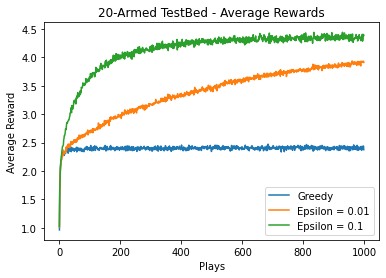

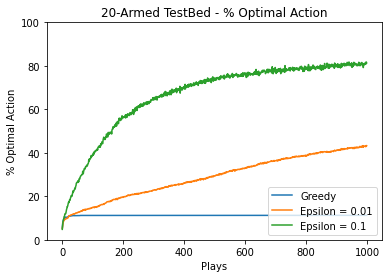

In [19]:
## Problem 1: recreate fig 2.2 with init 0 and modified testbed.
run_environment(arm_count=20,iterations=2000,plays=1000)

#### Explain any differences between your figure and the one in S&B. Do the curves converge to the same average reward?

Our modified testbed converges to a much higher reward for the more exploratory epsilon-random agents, while the greedy algorithm doesn't significantly learn past the initial gain.

###2. (2 points) Change the initial estimate value in the previous question from 0 to 20. Submit the new plots.

In [ ]:
run_environment(init_est=20)

#### Which curve benefits the most from this change?

The greedy algorithm benefited the most, since it found a higher reward than it did last time. Choosing an initial value closer to the goal also made the epsilon algorithms converge quicker.

###3. (2 points) Calculate the series of estimated action values after experiencing the following rewards when selecting the same bandit 5 times. First using alpha = 1/N. Then using a fixed step-size of alpha = 0.2

Reward sequence: R1 = 1, R2 = 5, R3 = 0, R4 = -1, R5 = 6

Answers should be two sets of five action values at each time point.


$$
\text{Using alpha 1/N}:\\
\begin{align}
Q_0 &= 0& \\
Q_1 &= Q_0 + \frac{1}{N}(R_1-Q_0)=0+1(1-0)=1\\
Q_2 &= Q_1 + \frac{1}{N}(R_2-Q_1)=1+0.5(5-1)=3\\
Q_3 &= Q_2 + \frac{1}{N}(R_3-Q_2)=3+\frac{1}{3}(0-3)=2\\
Q_4 &= Q_3 + \frac{1}{N}(R_4-Q_3)=2+\frac{1}{4}(-1-2)=1.25\\
Q_5 &= Q_4 + \frac{1}{N}(R_5-Q_4)=1.25+0.2(6-1.25)=2.2\\
\end{align}
$$

$$
\text{Using fixed step size 0.2}:\\
\begin{align}
Q_0 &= 0& \\
Q_1 &= Q_0 + 0.2(R_1-Q_0)=0+0.2(1-0)=0.2\\
Q_2 &= Q_1 + 0.2(R_2-Q_1)=0.2+0.2(5-0.2)=1.16\\
Q_3 &= Q_2 + 0.2(R_3-Q_2)=1.16+0.2(0-1.16)=0.928\\
Q_4 &= Q_3 + 0.2(R_4-Q_3)=0.928+0.2(-1-0.928)=0.5425\\
Q_5 &= Q_4 + 0.2(R_5-Q_4)=0.5424+0.2(6-0.5424)=1.6339\\
\end{align}
$$

### 4. (2 points) Exercise 2.8 from S&B: UCB Spikes In Figure 2.4 the UCB algorithm shows a distinct spike in performance on the 11th step. Why is this? Note that for your answer to be fully satisfactory it must explain both why the reward increases on the 11th step and why it decreases on the subsequent steps. Hint: If c = 1, then the spike is less prominent.

The bias dissapears once all actions have been selected at least once. But while we have that bias, the uncertainty decreases and the reward inflates. Once the initial arms are selected, typical thorough greedy-epsilon learning rate ensues.